In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [17]:
# **1. Memuat Dataset**
def load_dataset_from_folder(base_folder):
    folder_matang = os.path.join(base_folder, 'matang')
    folder_setengah_matang = os.path.join(base_folder, 'setengah_matang')
    folder_mentah = os.path.join(base_folder, 'mentah')

    def load_images(folder, label):
        images = []
        labels = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            try:
                img = load_img(img_path, target_size=(224, 224))  # Resize ke 224x224
                img_array = img_to_array(img) / 255.0  # Normalisasi
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        return images, labels

    images_matang, labels_matang = load_images(folder_matang, 0)
    images_setengah_matang, labels_setengah_matang = load_images(folder_setengah_matang, 1)
    images_mentah, labels_mentah = load_images(folder_mentah, 2)

    images = np.array(images_matang + images_setengah_matang + images_mentah)
    labels = np.array(labels_matang + labels_setengah_matang + labels_mentah)
    return images, labels

In [18]:
# Path ke folder dataset
base_folder = 'dataset_tomat'
X, y = load_dataset_from_folder(base_folder)

# Konversi label ke one-hot encoding
y = to_categorical(y, num_classes=3)

# Membagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# **2. Augmentasi Data**
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = data_gen.flow(X_train, y_train, batch_size=32)

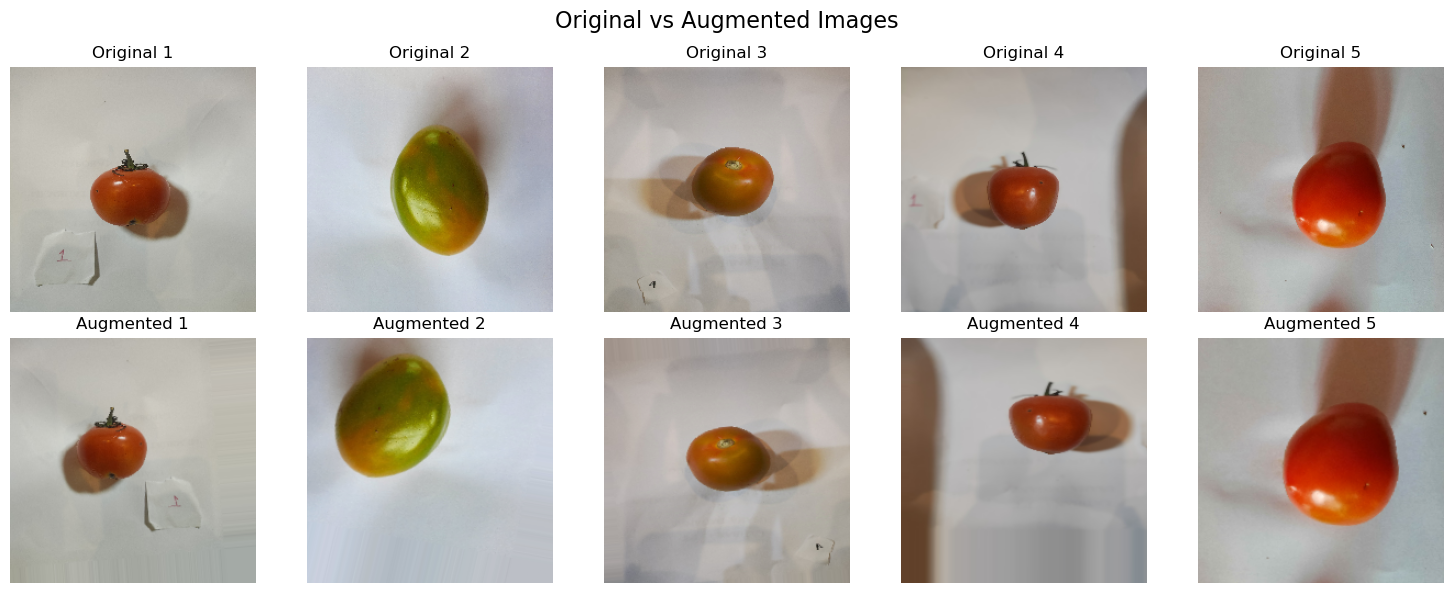

In [21]:
# Visualisasi augmentasi dengan gambar asli
def visualize_augmentation_with_original(generator, images, num_samples=5):
    if len(images) == 0:
        print("No images available for visualization.")
        return
    
    plt.figure(figsize=(15, 6))
    for i in range(min(num_samples, len(images))):
        original_image = images[i]  # Gambar asli
        augmented_image = next(generator.flow(np.expand_dims(images[i], axis=0), batch_size=1))[0]  # Augmentasi
        
        # Menampilkan gambar asli
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_image)
        plt.axis('off')
        plt.title(f"Original {i+1}")
        
        # Menampilkan augmentasi
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(augmented_image)
        plt.axis('off')
        plt.title(f"Augmented {i+1}")
    
    plt.suptitle("Original vs Augmented Images", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_augmentation_with_original(data_gen, X_train)

In [22]:
# **3. Membangun Model CNN**
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output untuk 3 kelas
])

In [23]:
# **4. Kompilasi Model**
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **5. Melatih Model**
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=(X_test, y_test)
)

C:\Users\sarwa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 791ms/step - accuracy: 0.3665 - loss: 2.6983 - val_accuracy: 0.4854 - val_loss: 1.0585
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 828ms/step - accuracy: 0.5201 - loss: 1.0101 - val_accuracy: 0.7864 - val_loss: 0.5929
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 800ms/step - accuracy: 0.7012 - loss: 0.6476 - val_accuracy: 0.9029 - val_loss: 0.4185
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 825ms/step - accuracy: 0.7991 - loss: 0.4471 - val_accuracy: 0.9417 - val_loss: 0.1622
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 790ms/step - accuracy: 0.9167 - loss: 0.2605 - val_accuracy: 0.9515 - val_loss: 0.1048
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 759ms/step - accuracy: 0.9048 - loss: 0.2894 - val_accuracy: 0.9612 - val_loss: 0.1176
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 776ms/step - accuracy: 0.9285 - loss: 0.2654 - val_accuracy: 0.9515 - val_loss: 0.1655
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 771ms/step - accuracy: 0.9113 - loss: 0.2163 - val_accu

In [24]:
# **6. Mengevaluasi Model**
# Mengevaluasi model menggunakan data pengujian
# Mengevaluasi akurasi pada data pelatihan untuk perbandingan
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Loss (Train): {train_loss:.4f}, Accuracy (Train): {train_accuracy:.4f}")

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f}, Accuracy (Test): {accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9114 - loss: 0.1897
Loss (Train): 0.1741, Accuracy (Train): 0.9338
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9358 - loss: 0.2710
Loss: 0.2178, Accuracy (Test): 0.9515


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step

Classification Report:
                 precision    recall  f1-score   support

         Matang       1.00      0.93      0.97        30
Setengah Matang       0.91      1.00      0.95        48
         Mentah       1.00      0.88      0.94        25

       accuracy                           0.95       103
      macro avg       0.97      0.94      0.95       103
   weighted avg       0.96      0.95      0.95       103



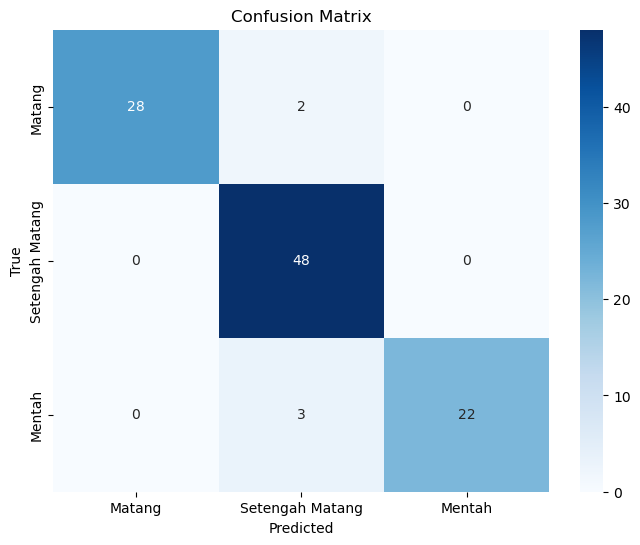

In [25]:
# **7. Analisis Hasil dengan Confusion Matrix**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Matang', 'Setengah Matang', 'Mentah']))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Matang', 'Setengah Matang', 'Mentah'], yticklabels=['Matang', 'Setengah Matang', 'Mentah'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

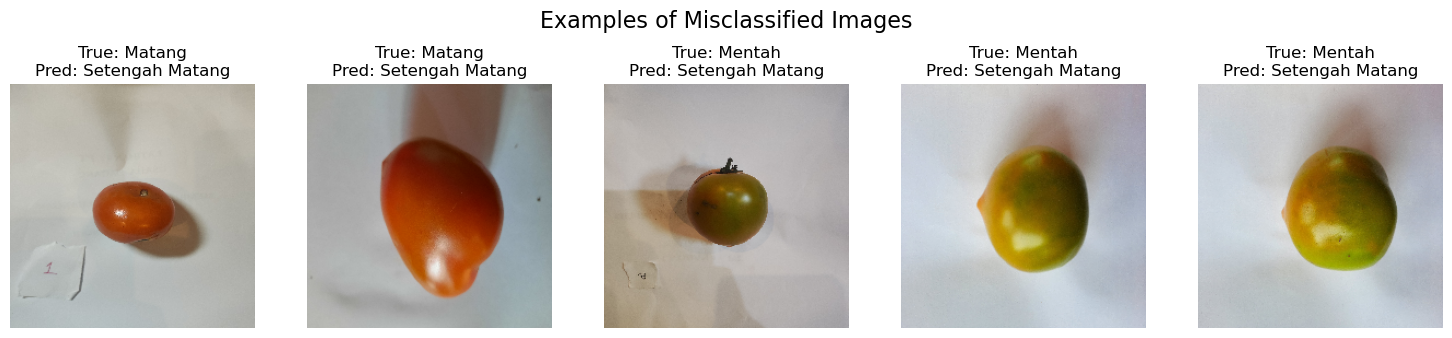

Plot disimpan sebagai 'misclassified_images.png'.


In [26]:

# **9. Menampilkan Prediksi yang Salah**

# Identifikasi indeks gambar yang salah diprediksi
incorrect_indices = [i for i in range(len(y_true_classes)) if y_true_classes[i] != y_pred_classes[i]]

# Jika ada prediksi yang salah, tampilkan
if incorrect_indices:
    plt.figure(figsize=(15, 5 * len(incorrect_indices) // 5 + 1))  # Sesuaikan ukuran figure
    for idx, i in enumerate(incorrect_indices):
        true_label = ['Matang', 'Setengah Matang', 'Mentah'][y_true_classes[i]]
        predicted_label = ['Matang', 'Setengah Matang', 'Mentah'][y_pred_classes[i]]

        plt.subplot(len(incorrect_indices) // 5 + 1, 5, idx + 1)
        plt.imshow(X_test[i])
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label}")

    plt.suptitle("Examples of Misclassified Images", fontsize=16)
    plt.tight_layout()

    # Simpan plot ke file
    plt.savefig("misclassified_images.png", dpi=300)
    plt.show()
    print("Plot disimpan sebagai 'misclassified_images.png'.")
else:
    print("No misclassified images found.")